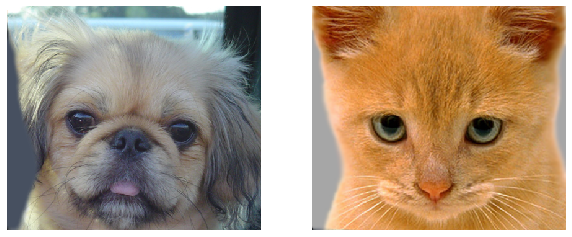

In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'


img_path = "../hw2_data/task1and2_hybrid_pyramid/3_dog.bmp"
img_path2 = "../hw2_data/task1and2_hybrid_pyramid/3_cat.bmp"
#img_path2 = "hw2_data/task1and2_hybrid_pyramid/6_makeup_after.jpg"
#img_path = "hw2_data/task1and2_hybrid_pyramid/6_makeup_before.jpg"

# img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
img = cv2.imread(img_path)[:,:,::-1]
img2 = cv2.imread(img_path2)[:,:,::-1]

plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img)

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(img2)

## [How to combine the phase of one image and magnitude of different image into 1 image by using python](https://stackoverflow.com/questions/52312053/how-to-combine-the-phase-of-one-image-and-magnitude-of-different-image-into-1-im)

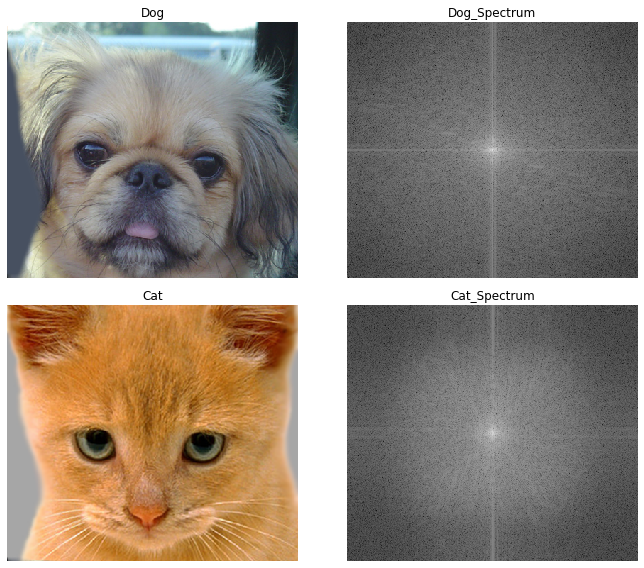

In [2]:
import numpy as np
import matplotlib


def Magnitude_Spectrum(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Compute the 2-dimensional discrete Fourier Transform
    frequency = np.fft.fft2(gray)

    # Shift the zero-frequency component to the center of the spectrum.
    frequency_shift = np.fft.fftshift(frequency)

    # Take absolute value and log to make pixels value between [0,255]
    magnitude_spectrum = np.log(np.abs(frequency_shift))
    
    return magnitude_spectrum

plt.subplot(2,2,1)
plt.axis('off')
plt.title('Dog')
plt.imshow(img)

plt.subplot(2,2,2)
plt.axis('off')
plt.title('Dog_Spectrum')
plt.imshow(Magnitude_Spectrum(img), cmap='gray')

plt.subplot(2,2,3)
plt.axis('off')
plt.title('Cat')
plt.imshow(img2)

plt.subplot(2,2,4)
plt.axis('off')
plt.title('Cat_Spectrum')
plt.imshow(Magnitude_Spectrum(img2), cmap='gray')
plt.tight_layout()

## [Lowpass Highpass - 雲林科技大學](http://mipl.yuntech.edu.tw/wp-content/uploads/2020/03/course_9814224953.pdf) 

## Ideal low & high pass filter

In [3]:
import math

def Ideal_filter(img, cutoff_ratio, low_or_high=True):

    h, w, channel = img.shape
    shape = min(h, w)
    ideal_filter = np.zeros((h, w))
    
    # The cut off operation is like  erasing the circle
    # Therefore we need to find the shortest image boundary
    # Divided by 2 to find the radius
    cutoff_frequency = math.ceil(shape / 2 * cutoff_ratio)
    
    
    # Transform the pixel position into center of circle's offset
    # e.g. [0, 1, 2, 3] -> [-1.5, -0.5, 0.5, 1.5] ,(4-1)/2 
    # e.g. [0, 1, 2, 3, 4] -> [-2, -1, 0, 1, 2]  ,(5-1)/2
    u_offset = (h-1) / 2
    v_offset = (w-1) / 2

    for u in range(h):
        shift_u = u - u_offset

        for v in range(w):
            shift_v = v - v_offset
            Distance = (shift_u**2 + shift_v**2)**(0.5)

            # According to the ideal low pass filter formula H
            if (Distance <= cutoff_frequency):
                ideal_filter[u, v] = 1
    
    if not low_or_high:
        ideal_filter = 1 - ideal_filter
    
    # To hold some overflow value
    filtered_image = np.zeros_like(img, dtype='float64')
    filtered_spectrum = np.zeros_like(img, dtype='float64')
    
    for c in range(channel):

        frequency = np.fft.fft2(img[:,:,c])
        shifted_frequency = np.fft.fftshift(frequency)
        filtered_frequency = shifted_frequency * ideal_filter
        filtered_spectrum[...,c] = np.log(np.abs(filtered_frequency) + 1) # add 1 to avoid "divided by zero" exception
        filtered_image[...,c] = np.fft.ifft2(np.fft.ifftshift(filtered_frequency)).real
    
    filtered_image = np.where(filtered_image>255, 255, filtered_image)
    filtered_image = np.where(filtered_image<0, 0, filtered_image)

    return filtered_image, filtered_spectrum

### Ideal low pass filter

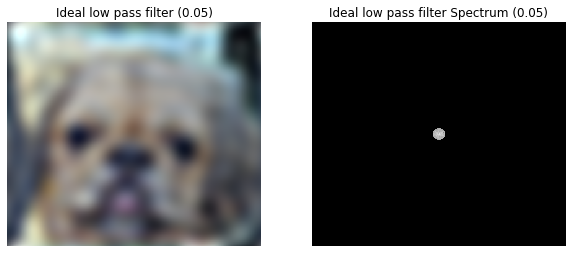

In [4]:
cutoff_frequency = 0.05
low_filter_image, low_filter_spectrum = Ideal_filter(img, cutoff_frequency, low_or_high=True)

plt.subplot(1,2,1)
plt.axis('off')
plt.title('Ideal low pass filter (0.05)')
plt.imshow(low_filter_image.astype('uint8'))

plt.subplot(1,2,2)
plt.axis('off')
plt.title('Ideal low pass filter Spectrum (0.05)')
plt.imshow(low_filter_spectrum[:,:,0], cmap='gray')

### Ideal high pass filter

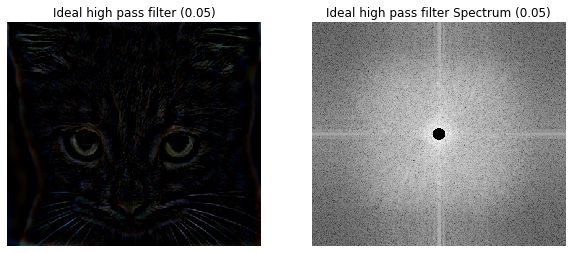

In [5]:
cutoff_frequency = 0.05
high_filter_image, high_filter_spectrum = Ideal_filter(img2, cutoff_frequency, low_or_high=False)


plt.imshow(low_filter_spectrum[:,:,0], cmap='gray')
plt.subplot(1,2,1)
plt.axis('off')
plt.title('Ideal high pass filter (0.05)')
plt.imshow(high_filter_image.astype('uint8'))

plt.subplot(1,2,2)
plt.axis('off')
plt.title('Ideal high pass filter Spectrum (0.05)')
plt.imshow(high_filter_spectrum[:,:,0], cmap='gray')

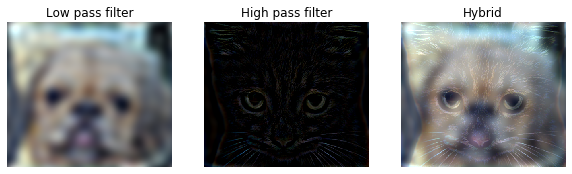

In [6]:
def Hybrid_image(img1, img2, cutoff_ratio, method):
    
    min_h = min(img1.shape[0], img2.shape[0])
    min_w = min(img1.shape[1], img2.shape[1])
    hybrid_img = np.zeros((min_h, min_w), dtype='float64')
    
    
    
    low_pass_img, low_pass_spectrum = method(img1, cutoff_ratio, True)
    
    high_pass_img, high_pass_spectrum = method(img2, cutoff_ratio, False)
    hybrid_img = low_pass_img[0:min_h, 0:min_w] + high_pass_img[0:min_h, 0:min_w]
    hybrid_img = np.where(hybrid_img>255, 255, hybrid_img)

    return hybrid_img

hyrid_img = Hybrid_image(img, img2, 0.05, Ideal_filter)
plt.subplot(1,3,1)
plt.axis('off')
plt.title('Low pass filter')
plt.imshow(low_filter_image.astype('uint8'))

plt.subplot(1,3,2)
plt.axis('off')
plt.title('High pass filter')
plt.imshow(high_filter_image.astype('uint8'))

plt.subplot(1,3,3)
plt.axis('off')
plt.title('Hybrid')
plt.imshow(hyrid_img.astype('uint8'))

## Gaussian filter

In [7]:
def Gaussian_filter(img, cutoff_ratio, low_or_high=True):

    h, w, channel = img.shape
    shape = min(h, w)
    gaussian_filter = np.zeros((h, w))
    
    # The cut off operation is like  erasing the circle
    # Therefore we need to find the shortest image boundary
    # Divided by 2 to find the radius
    cutoff_frequency = math.ceil(shape / 2 * cutoff_ratio)
    
    
    # Transform the pixel position into center of circle's offset
    # e.g. [0, 1, 2, 3] -> [-1.5, -0.5, 0.5, 1.5] ,(4-1)/2 
    # e.g. [0, 1, 2, 3, 4] -> [-2, -1, 0, 1, 2]  ,(5-1)/2
    u_offset = (h-1) / 2
    v_offset = (w-1) / 2

    for u in range(h):
        shift_u = u - u_offset

        for v in range(w):
            shift_v = v - v_offset
            Distance = (shift_u**2 + shift_v**2)**(0.5)

            # According to the Gaussian low pass filter formula H
            gaussian_filter[u,v] = math.e**(-(Distance)**2 / (2*cutoff_frequency**2))
    
    if not low_or_high:
        gaussian_filter = 1 - gaussian_filter

    # To hold some overflow value
    filtered_image = np.zeros_like(img, dtype='float64')
    filtered_spectrum = np.zeros_like(img, dtype='float64')
    
    for c in range(channel):

        frequency = np.fft.fft2(img[:,:,c])
        shifted_frequency = np.fft.fftshift(frequency)
        filtered_frequency = shifted_frequency * gaussian_filter
        filtered_spectrum[...,c] = np.log(np.abs(filtered_frequency) + 1) # add 1 to avoid "divided by zero" exception
        # The inverse of fftshift.
        # And compute the 2-dimensional inverse discrete Fourier Transform.
        # To retrive the RGB image from fourier transform
        filtered_image[...,c] = np.fft.ifft2(np.fft.ifftshift(filtered_frequency)).real

    filtered_image = np.where(filtered_image<0, 0, filtered_image)

    return filtered_image, filtered_spectrum

### Gaussian low pass filter

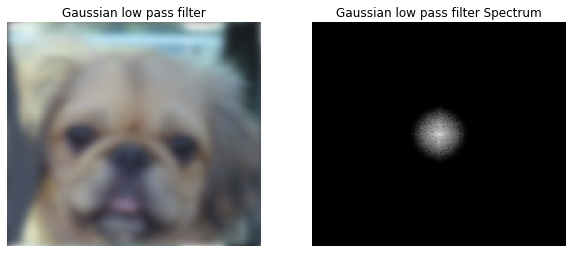

In [8]:
cutoff_frequency = 0.05
low_filter_image, low_filter_spectrum = Gaussian_filter(img, cutoff_frequency, True)


plt.subplot(1,2,1)
plt.axis('off')
plt.title('Gaussian low pass filter')
plt.imshow(low_filter_image.astype('uint8'))

plt.subplot(1,2,2)
plt.axis('off')
plt.title('Gaussian low pass filter Spectrum')
plt.imshow(low_filter_spectrum[:,:,0], cmap='gray')

### Gaussian high pass filter

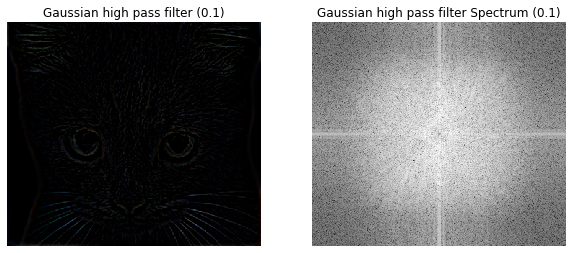

In [9]:
cutoff_frequency = 0.1
high_filter_image, high_filter_spectrum = Gaussian_filter(img2, cutoff_frequency, False)


plt.subplot(1,2,1)
plt.axis('off')
plt.title('Gaussian high pass filter (0.1)')
plt.imshow(high_filter_image.astype('uint8'))

plt.subplot(1,2,2)
plt.axis('off')
plt.title('Gaussian high pass filter Spectrum (0.1)')
plt.imshow(high_filter_spectrum[:,:,0], cmap='gray')

In [10]:
"""
def Hybrid_image(img1, img2, cutoff_ratio, method):
    
    max_h = max(img1.shape[0], img2.shape[0])
    max_w = max(img1.shape[1], img2. shape[1])
    hybrid_img = np.zeros((max_h, max_w), dtype='float64')
    
    # Normalization
    img1 = img1 / 255.
    img2 = img2 / 255.
    
    
    low_pass_img, low_pass_spectrum = method(img1, cutoff_ratio, True)
    
    high_pass_img, high_pass_spectrum = method(img2, cutoff_ratio, False)
    hybrid_img = low_pass_img + high_pass_img
    hybrid_img = (hybrid_img - hybrid_img.min()) / (hybrid_img.max() - hybrid_img.min())
    
    return hybrid_img

hyrid_img = Hybrid_image(img, img2, 0.06, Gaussian_filter)
plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(low_filter_image.astype('uint8'))

plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(high_filter_image.astype('uint8'))

plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(hyrid_img)
"""

"\ndef Hybrid_image(img1, img2, cutoff_ratio, method):\n    \n    max_h = max(img1.shape[0], img2.shape[0])\n    max_w = max(img1.shape[1], img2. shape[1])\n    hybrid_img = np.zeros((max_h, max_w), dtype='float64')\n    \n    # Normalization\n    img1 = img1 / 255.\n    img2 = img2 / 255.\n    \n    \n    low_pass_img, low_pass_spectrum = method(img1, cutoff_ratio, True)\n    \n    high_pass_img, high_pass_spectrum = method(img2, cutoff_ratio, False)\n    hybrid_img = low_pass_img + high_pass_img\n    hybrid_img = (hybrid_img - hybrid_img.min()) / (hybrid_img.max() - hybrid_img.min())\n    \n    return hybrid_img\n\nhyrid_img = Hybrid_image(img, img2, 0.06, Gaussian_filter)\nplt.subplot(1,3,1)\nplt.axis('off')\nplt.imshow(low_filter_image.astype('uint8'))\n\nplt.subplot(1,3,2)\nplt.axis('off')\nplt.imshow(high_filter_image.astype('uint8'))\n\nplt.subplot(1,3,3)\nplt.axis('off')\nplt.imshow(hyrid_img)\n"

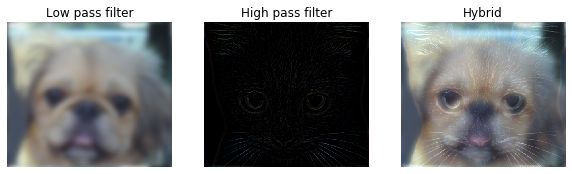

In [11]:
def Hybrid_image(img1, img2, cutoff_ratio, method):
    
    min_h = min(img1.shape[0], img2.shape[0])
    min_w = min(img1.shape[1], img2. shape[1])
    hybrid_img = np.zeros((min_h, min_w), dtype='float64')
    
    
    
    low_pass_img, low_pass_spectrum = method(img1, cutoff_ratio, True)
    
    high_pass_img, high_pass_spectrum = method(img2, cutoff_ratio, False)
    hybrid_img = low_pass_img[0:min_h, 0:min_w] + high_pass_img[0:min_h, 0:min_w]
    hybrid_img = np.where(hybrid_img>255, 255, hybrid_img)

    return hybrid_img

hyrid_img = Hybrid_image(img, img2, 0.05, Gaussian_filter)
plt.subplot(1,3,1)
plt.axis('off')
plt.title('Low pass filter')
plt.imshow(low_filter_image.astype('uint8'))

plt.subplot(1,3,2)
plt.axis('off')
plt.title('High pass filter')
plt.imshow(high_filter_image.astype('uint8'))

plt.subplot(1,3,3)
plt.axis('off')
plt.title('Hybrid')
plt.imshow(hyrid_img.astype('uint8'))